In [1]:
from model import *
from preprocess import *
from train import *
from utils import *
from decode import *

In [2]:
raw_text = read_data_nmt('fra.txt') # len: 11489286

In [3]:
text = preprocess_nmt(raw_text) # len: same as raw_text
print(text[:80])

go .	va !
hi .	salut !
run !	cours !
run !	courez !
who ?	qui ?
wow !	ça alors !


In [4]:
source, target = tokenize_nmt(text)
source[:6], target[:6]

([['go', '.'],
  ['hi', '.'],
  ['run', '!'],
  ['run', '!'],
  ['who', '?'],
  ['wow', '!']],
 [['va', '!'],
  ['salut', '!'],
  ['cours', '!'],
  ['courez', '!'],
  ['qui', '?'],
  ['ça', 'alors', '!']])

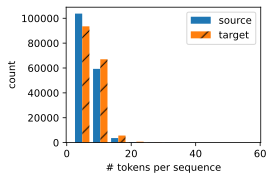

In [5]:
show_list_len_pair_hist(['source', 'target'], '# tokens per sequence',
                        'count', source, target)

In [6]:
train_iter, src_vocab, tgt_vocab = load_data_nmt(batch_size=2, num_steps=8)
for X, X_valid_len, Y, Y_valid_len in train_iter:
    print('X:', X.type(torch.int32))
    print('valid lengths for X:', X_valid_len)
    print('Y:', Y.type(torch.int32))
    print('valid lengths for Y:', Y_valid_len)
    break

Source Len: 167130, Target Len: 167130
Source Vocab Size: 10012, Target Vocab Size: 17851
Source Array Shape: torch.Size([167130, 8]), Target Array Shape: torch.Size([167130, 8])


In [2]:
encoder = Seq2SeqEncoder(vocab_size=10, embed_size=8, num_hiddens=16,
                         num_layers=2)
encoder.eval()

batch_size, num_steps =4, 7
X = torch.zeros((batch_size, num_steps), dtype=torch.long)
output, state = encoder(X)

In [3]:
decoder = Seq2SeqDecoder(vocab_size=10, embed_size=8, num_hiddens=16,
                         num_layers=2)
decoder.eval()
X = torch.zeros((batch_size, num_steps), dtype=torch.long)
state = decoder.init_state(encoder(X))
output, state = decoder(X, state)

In [10]:
loss = MaskedSoftmaxCELoss()
loss(torch.ones(3, 4, 10), torch.ones((3, 4), dtype=torch.long),torch.tensor([4, 2, 0]))

tensor([9.2103, 4.6052, 0.0000])

In [4]:
embed_size, num_hiddens, num_layers, dropout = 32, 32, 2, 0.1
batch_size, num_steps = 64, 10
lr, num_epochs, device = 0.005, 100, d2l.try_gpu()

train_iter, src_vocab, tgt_vocab = load_data_nmt(batch_size, num_steps)
encoder = Seq2SeqEncoder(
    len(src_vocab), embed_size, num_hiddens, num_layers, dropout)
decoder = Seq2SeqDecoder(
    len(tgt_vocab), embed_size, num_hiddens, num_layers, dropout)
net = d2l.EncoderDecoder(encoder, decoder)
# train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device)


Source Len: 167130, Target Len: 167130
[['two', 'male', 'construction', 'workers', 'are', 'working', 'on', 'a', 'street', 'outside', 'someone', '&apos;s', 'home'], ['an', 'elderly', 'man', 'sits', 'outside', 'a', 'storefront', 'accompanied', 'by', 'a', 'young', 'boy', 'with', 'a', 'cart', '.'], ['a', 'man', 'in', 'shorts', 'and', 'a', 'hawaiian', 'shirt', 'leans', 'over', 'the', 'rail', 'of', 'a', 'pilot', 'boat', ',', 'with', 'fog', 'and', 'mountains', 'in', 'the', 'background', '.']] [['deux', 'ouvriers', 'travaillent', 'sur', 'la', 'rue', 'à', 'l&apos;', 'extérieur', 'de', 'chez', 'quelqu&apos;', 'un'], ['un', 'vieil', 'homme', 'est', 'assis', 'devant', 'une', 'vitrine', 'accompagné', 'd&apos;', 'un', 'jeune', 'garçon', 'avec', 'un', 'panier', '.'], ['un', 'homme', 'en', 'short', 'et', 'chemise', 'hawaïenne', 'se', 'penche', 'par', 'dessus', 'le', 'bastingage', 'd&apos;', 'un', 'bateau', ',', 'avec', 'le', 'brouillard', 'et', 'les', 'montagnes', 'en', 'arrière-plan', '.']]
Source Le

In [5]:
net

EncoderDecoder(
  (encoder): Seq2SeqEncoder(
    (embedding): Embedding(12890, 32)
    (rnn): GRU(32, 32, num_layers=2, dropout=0.1)
  )
  (decoder): Seq2SeqDecoder(
    (embedding): Embedding(21062, 32)
    (rnn): GRU(64, 32, num_layers=2, dropout=0.1)
    (dense): Linear(in_features=32, out_features=21062, bias=True)
  )
)

In [15]:
engs = ['go .', "i lost .", 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
for eng, fra in zip(engs, fras):
    translation, attention_weight_seq = predict_seq2seq(
        net, eng, src_vocab, tgt_vocab, num_steps, device)
    print(f'{eng} => {translation}, bleu {bleu(translation, fra, k=2):.3f}')

go . => va !, bleu 1.000
i lost . => je me suis perdu ., bleu 0.447
he's calm . => il est en train ., bleu 0.548
i'm home . => je suis est chez moi je montre maison montre montre, bleu 0.434


In [3]:
from preprocess import *
from utils import *
import torch
import matplotlib.pyplot as plt
import numpy as np
from d2l import torch as d2l

In [20]:
def predict_seq2seq(net, src_sentence, src_vocab, tgt_vocab, num_steps,
                    device, save_attention_weights=False, debug = True):
    """Predict for sequence to sequence."""
    # Set `net` to eval mode for inference
    net.eval()
    src_tokens = src_vocab[src_sentence.lower().split(' ')] + [
        src_vocab['<eos>']]
    if debug == True:
        print(f'src_tokens: {src_tokens}')
    enc_valid_len = torch.tensor([len(src_tokens)], device=device)
    src_tokens = d2l.truncate_pad(src_tokens, num_steps, src_vocab['<pad>'])
    # Add the batch axis
    enc_X = torch.unsqueeze(
        torch.tensor(src_tokens, dtype=torch.long, device=device), dim=0)
    enc_outputs = net.encoder(enc_X, enc_valid_len)
    dec_state = net.decoder.init_state(enc_outputs, enc_valid_len)
    # Add the batch axis
    dec_X = torch.unsqueeze(torch.tensor(
        [tgt_vocab['<bos>']], dtype=torch.long, device=device), dim=0)
    output_seq, attention_weight_seq = [], []
    if debug:
        print(f'src_sentence: {src_sentence}')
        print(f'enc_valid_len: { enc_valid_len}')
        print(f'src_tokens_truncate: {src_tokens}')
        print(f'enc_X: {enc_X}')
        print(f'enc_outputs: {enc_outputs}')
        print(f'dec_state: {dec_state}')
        print(f'dec_X: {dec_X}')
        # print(f': {}')
        # print(f': {}')
        # print(f': {}')
    for _ in range(num_steps):
        Y, dec_state = net.decoder(dec_X, dec_state)
        # We use the token with the highest prediction likelihood as the input
        # of the decoder at the next time step
        dec_X = Y.argmax(dim=2)
        pred = dec_X.squeeze(dim=0).type(torch.int32).item()
        # Save attention weights (to be covered later)
        if save_attention_weights:
            attention_weight_seq.append(net.decoder.attention_weights)
        # Once the end-of-sequence token is predicted, the generation of the
        # output sequence is complete
        if debug:
            print(f'Y: {Y} Y shape: {Y.shape}')
            print(f'dec_X: {dec_X}')
            print(f'pred: {pred}')
            print(f'Y around: {Y[:,:,pred-5:pred+5]}')
            
        if pred == tgt_vocab['<eos>']:
            break
        output_seq.append(pred)
    return ' '.join(tgt_vocab.to_tokens(output_seq)), attention_weight_seq


In [21]:
en = read_data_nmt('val.lc.norm.tok.en')
engs = en.split('\n')
fr = read_data_nmt('val.lc.norm.tok.fr')
fras = fr.split('\n')

net = torch.load('Seq2Seq.pt')
net.eval()
device = d2l.try_gpu()
num_steps = 14
src_vocab = torch.load('src_vocab.pth')
tgt_vocab = torch.load('tgt_vocab.pth')
bleu_dist = []
for eng, fra in zip(engs[:1], fras[:1]):
    translation, attention_weight_seq = predict_seq2seq(
        net, eng, src_vocab, tgt_vocab, num_steps, device)
    print(f'{eng} => {translation}, bleu {bleu(translation, fra, k=1):.3f}')
    bleu_dist.append(bleu(translation, fra, k=1))
# plt.hist(bleu_dist, bins=100)
# plt.gca().set(title='BLEU Score Frequency Histogram: Greedy Decode', ylabel='Frequency',xlabel='BLEU Score')
# plt.savefig('evaluate.png')
# print(f'Average {round(sum(bleu_dist)/len(bleu_dist),3)}, variance {np.var(bleu_dist)}')

src_tokens: [5, 131, 13, 110, 19, 4010, 3803, 1032, 5, 763, 3]
src_sentence: a group of men are loading cotton onto a truck
enc_valid_len: tensor([11], device='cuda:0')
src_tokens_truncate: [5, 131, 13, 110, 19, 4010, 3803, 1032, 5, 763, 3, 1, 1, 1]
enc_X: tensor([[   5,  131,   13,  110,   19, 4010, 3803, 1032,    5,  763,    3,    1,
            1,    1]], device='cuda:0')
enc_outputs: (tensor([[[ 0.2461,  0.6369, -0.0196,  0.1306,  0.0067, -0.2021,  0.1123,
          -0.4221, -0.2344,  0.0411,  0.2219, -0.8588, -0.1506, -0.3272,
           0.1666, -0.6688, -0.0866,  0.5777,  0.4225, -0.3494,  0.9129,
          -0.0278,  0.4479,  0.0960,  0.7349,  0.0384,  0.1253,  0.0198,
           0.3064,  0.0453,  0.1253, -0.1800]],

        [[ 0.9702,  0.6380, -0.0091,  0.0671,  0.0744, -0.4405,  0.1011,
           0.0975, -0.0527,  0.0051,  0.2190, -0.1260, -0.1921, -0.7192,
           0.2294, -0.9915, -0.1826,  0.1907,  0.4897, -0.2141,  0.9885,
          -0.0403,  0.5782, -0.0099,  0.9510,  0